In [1]:
#Import libraries

import numpy as np
from numpy.random import random_integers
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import pointbiserialr, spearmanr
%matplotlib inline

print('Libraries Ready!')

Libraries Ready!


In [3]:
#Load training data

path = ''
df = pd.read_csv(path+'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


####Process Data

People with stronger titles tend to have more help on board. Hence, we will categorize passengers based on titles.

In [4]:
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    } 

df['Title'] = df['Name'].apply(lambda x: Title_Dictionary[x.split(',')[1].split('.')[0].strip()])

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


The ticket prefix may determine the status or cabin on board and hence will be included

In [5]:
def Ticket_Prefix(s):
    s=s.split()[0]
    if s.isdigit():
        return 'NoClue'
    else:
        return s

df['TicketPrefix'] = df['Ticket'].apply(lambda x: Ticket_Prefix(x))

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,NoClue
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NoClue


Now let's check for data types and missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Name            891 non-null object
Sex             891 non-null object
Age             714 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Ticket          891 non-null object
Fare            891 non-null float64
Cabin           204 non-null object
Embarked        889 non-null object
Title           891 non-null object
TicketPrefix    891 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 97.5+ KB


We can see that Age and Embarked has missing data.

Simply dropping the Age NaNs would mean throwing away too much data.

We add in the median age based on the Title, Pclass and Sex of each passenger.

In [7]:
mask_Age = df.Age.notnull()
Age_Sex_Title_Pclass = df.loc[mask_Age, ["Age", "Title", "Sex", "Pclass"]]
Filler_Ages = Age_Sex_Title_Pclass.groupby(by = ["Title", "Pclass", "Sex"]).median()
Filler_Ages = Filler_Ages.Age.unstack(level = -1).unstack(level = -1)

mask_Age = df.Age.isnull()
Age_Sex_Title_Pclass_missing = df.loc[mask_Age, ["Title", "Sex", "Pclass"]]

def Age_filler(row):
    if row.Sex == "female":
        age = Filler_Ages.female.loc[row["Title"], row["Pclass"]]
        return age
    
    elif row.Sex == "male":
        age = Filler_Ages.male.loc[row["Title"], row["Pclass"]]
        return age
    
Age_Sex_Title_Pclass_missing["Age"]  = Age_Sex_Title_Pclass_missing.apply(Age_filler, axis = 1)   

df["Age"] = pd.concat([Age_Sex_Title_Pclass["Age"], Age_Sex_Title_Pclass_missing["Age"]])    

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,NoClue
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NoClue


Next we fill in the missing Fare.

In [8]:
df['Fare']=df['Fare'].fillna(value=df.Fare.mean())
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,NoClue
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NoClue


We do not need Cabin and Ticket and hence can be dropped from our DataFrame.

We also can combine SibSp and Parch to FamilySize.

In [9]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df = df.drop(['Ticket', 'Cabin'], axis=1)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,TicketPrefix,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,A/5,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,PC,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,STON/O2.,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,NoClue,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,NoClue,0


Now we deal with categorical data using dummy variables.

In [10]:
dummies_Sex=pd.get_dummies(df['Sex'],prefix='Sex')
dummies_Embarked = pd.get_dummies(df['Embarked'], prefix= 'Embarked') 
dummies_Pclass = pd.get_dummies(df['Pclass'], prefix= 'Pclass')
dummies_Title = pd.get_dummies(df['Title'], prefix= 'Title')
dummies_TicketPrefix = pd.get_dummies(df['TicketPrefix'], prefix='TicketPrefix')
df = pd.concat([df, dummies_Sex, dummies_Embarked, dummies_Pclass, dummies_Title, dummies_TicketPrefix], axis=1)
df = df.drop(['Sex','Embarked','Pclass','Title','Name','TicketPrefix'], axis=1)

df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,...,TicketPrefix_SOTON/O.Q.,TicketPrefix_SOTON/O2,TicketPrefix_SOTON/OQ,TicketPrefix_STON/O,TicketPrefix_STON/O2.,TicketPrefix_SW/PP,TicketPrefix_W./C.,TicketPrefix_W.E.P.,TicketPrefix_W/C,TicketPrefix_WE/P
0,1,0,22.0,1,0,7.2500,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,38.0,1,0,71.2833,1,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,26.0,0,0,7.9250,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,1,35.0,1,0,53.1000,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,35.0,0,0,8.0500,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, we set our PassengerId as our index.

In [13]:
df = df.set_index(['PassengerId'])
df.head()

KeyError: 'PassengerId'

####Feature Selection

For feature selection, we will look at the correlation of each feature against Survived.
Based on our data types, we will use the following aglorithms:

- Spearman-Rank correlation for nominal vs nominal data
- Point-Biserial correlation for nominal vs continuous data

In [14]:
columns = df.columns.values

param=[]
correlation=[]
abs_corr=[]

for c in columns:
    #Check if binary or continuous
    if len(df[c].unique())<=2:
        corr = spearmanr(df['Survived'],df[c])[0]
    else:
        corr = pointbiserialr(df['Survived'],df[c])[0]
    param.append(c)
    correlation.append(corr)
    abs_corr.append(abs(corr))

#Create dataframe for visualization
param_df=pd.DataFrame({'correlation':correlation,'parameter':param, 'abs_corr':abs_corr})

#Sort by absolute correlation
param_df=param_df.sort_values(by=['abs_corr'], ascending=False)

#Set parameter name as index
param_df=param_df.set_index('parameter')

param_df.head()

,abs_corr,correlation
parameter,,
Survived,1.000000,1.000000
Title_Mr,0.549199,-0.549199
Sex_male,0.543351,-0.543351
Sex_female,0.543351,0.543351
Title_Mrs,0.344935,0.344935


Now that we have our correlation, we can use the Decision Tree classifier to see the score agaisnt feature space.

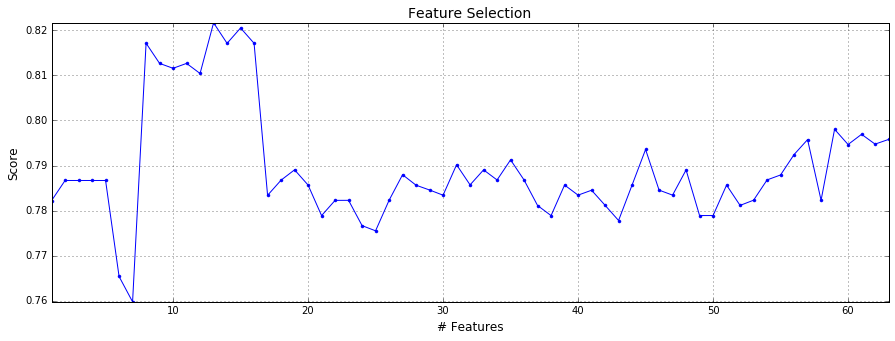

In [15]:
scoresCV = []
scores = []

for i in range(1,len(param_df)):
    new_df=df[param_df.index[0:i+1].values]
    X = new_df.ix[:,1::]
    y = new_df.ix[:,0]
    clf = DecisionTreeClassifier()
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
    
plt.figure(figsize=(15,5))
plt.plot(range(1,len(scores)+1),scores, '.-')
plt.axis("tight")
plt.title('Feature Selection', fontsize=14)
plt.xlabel('# Features', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid();

Based on the plot, a feature space of 10 dimensions provides the most reliable result while avoiding overfit.

In [16]:
best_features=param_df.index[1:10+1].values
print('Best features:\t',best_features)

Best features:	 ['Title_Mr' 'Sex_male' 'Sex_female' 'Title_Mrs' 'Title_Miss' 'Pclass_3'
 'Pclass_1' 'Fare' 'Embarked_C' 'Embarked_S']


Looking at out best features.

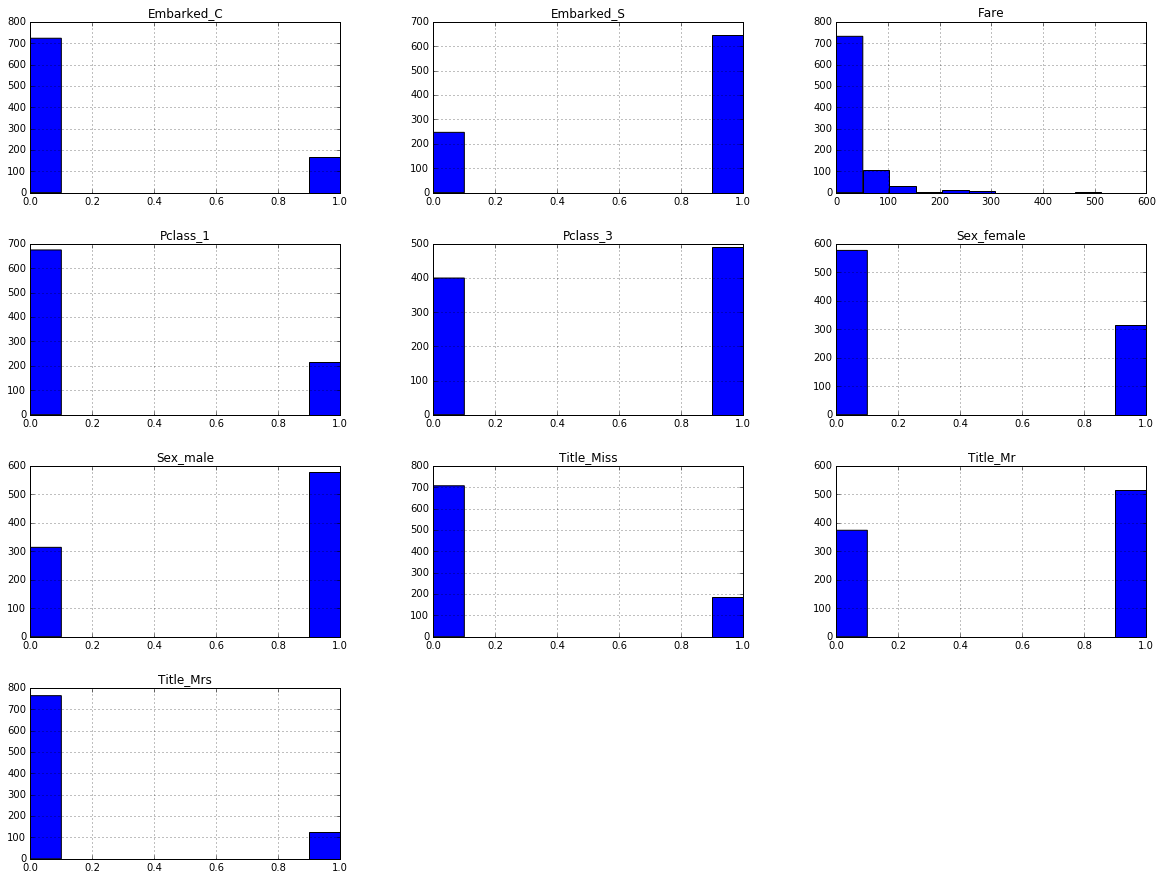

In [17]:
df[best_features].hist(figsize=(20,15));

Creating the train and test datasets.

In [18]:
X = df[best_features]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)

####Decision Tree

Analyzing the different parameters of Decision Trees.

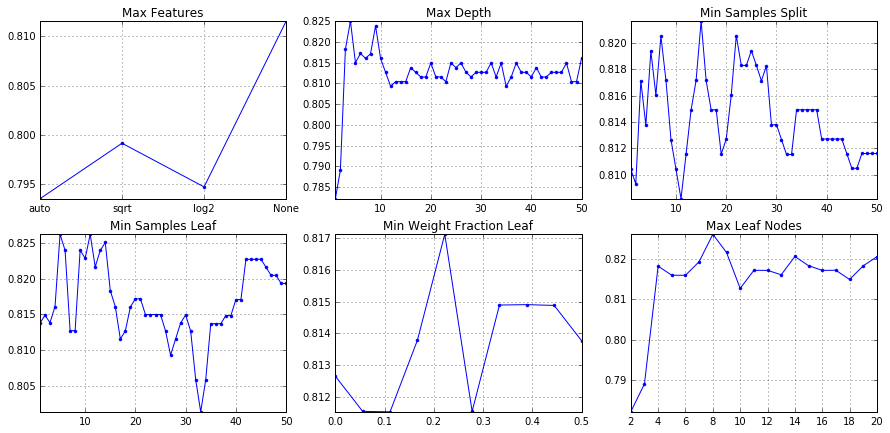

In [19]:
plt.figure(figsize=(15,7))

#Max Features
plt.subplot(2,3,1)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(2,3,2)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(2,3,3)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Samples Leaf
plt.subplot(2,3,4)
feature_param = range(1,51)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Leaf')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(2,3,5)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(2,3,6)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = DecisionTreeClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = sklearn.cross_validation.cross_val_score(clf, X, y, cv= 10)
    scores.append(np.mean(scoreCV))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

- Max Depth show high score variance with change in parameter.
- All otehr parameters show low score variance.

####Random Forest Classifier

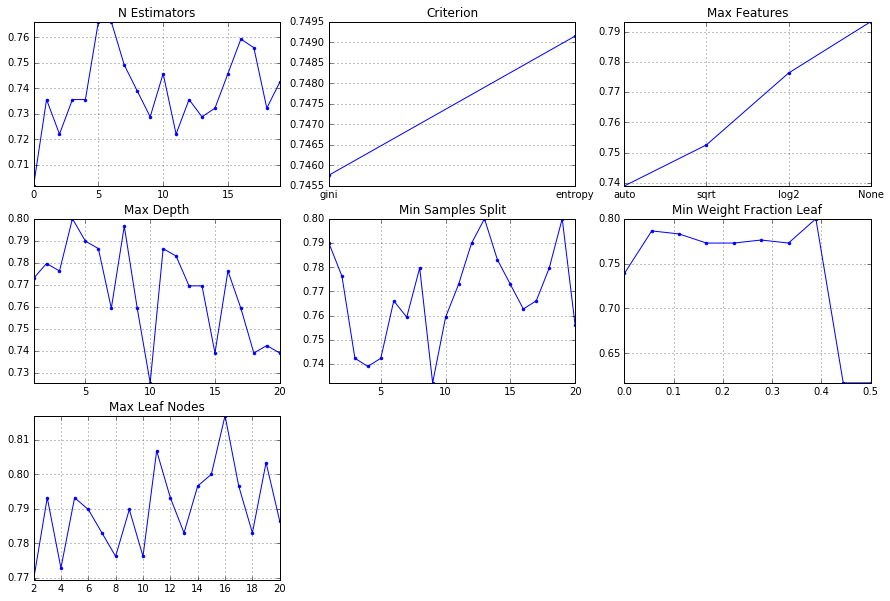

In [20]:
plt.figure(figsize=(15,10))

#N Estimators
plt.subplot(3,3,1)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('N Estimators')
plt.grid();

#Criterion
plt.subplot(3,3,2)
feature_param = ['gini','entropy']
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(criterion=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Criterion')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(3,3,4)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(3,3,5)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

- Random Forest seems to show high variance in scores with most parameter changes.
- Max Features, Criterion and Max Leaf Nodes show low variance in scores.
- The general high varience in N Estimator plot shows the risk of overfitting.

####Gradient Boosting

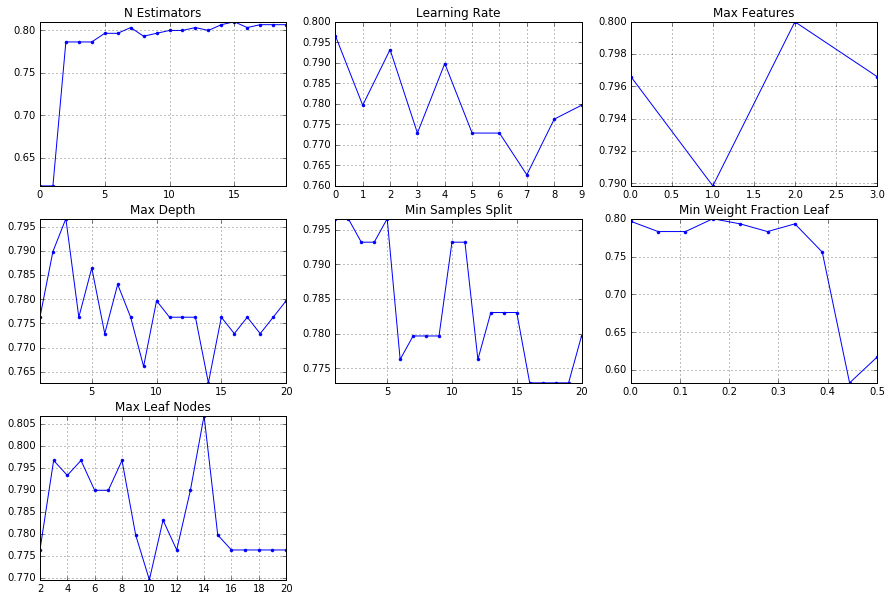

In [21]:
plt.figure(figsize=(15,10))

#N Estimators
plt.subplot(3,3,1)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('N Estimators')
plt.grid();

#Learning Rate
plt.subplot(3,3,2)
feature_param = np.linspace(0.1,1,10)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(learning_rate=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Learning Rate')
plt.grid();

#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.grid();

#Max Depth
plt.subplot(3,3,4)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(3,3,5)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = GradientBoostingClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

- The N Estimator plot seems very stable and hence resistant to overfitting.
- Min Weight Fraction Leaf drops significantly after a certain point.
- All other plots show very little variance.

####Decision Surface

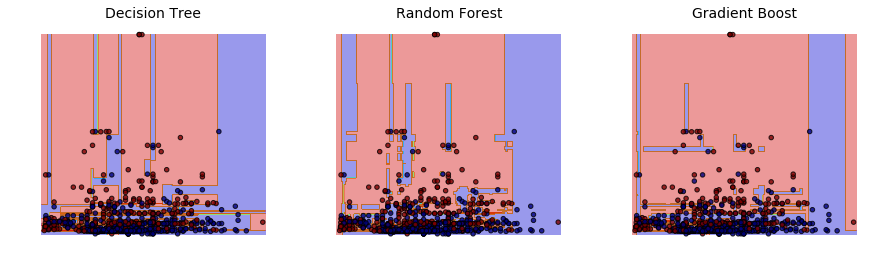

In [22]:
#Plotting dicision boundries with columns Age and Fare. 
from itertools import product

#Picking Age and Fare as they are continuous and highly correlated with Survived
X = df[['Age', 'Fare']].values
y = df['Survived'].values

# Training classifiers
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = GradientBoostingClassifier()

#Fit models
clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,4))

for idx, clf, tt in zip(range(3),
                        [clf1, clf2, clf3],
                        ['Decision Tree', 'Random Forest',
                         'Gradient Boost']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx].scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    axarr[idx].set_title(tt, fontsize=14)
    axarr[idx].axis('off')

All 3 plots are similar on the right side in terms of classification by initially splitting at Age. The second split occurs at the bottom for Fare. Discrepensies in classification occur as we move further than 2 splits. As more branches are forming, Decision Tree and Random Forest risk overfitting as they try to form more pure leaves. Relatively, Gradient Boost seem to be forming less branches and hence resistant to overfitting.